# <center>Modulation Introductory Demo</center>

This demo includes a graphical interface to specify the module's properties and is meant as an introduction to it's functionality. The **Modulation**, **Labels**, **Amplitude** and **Phase offset** fields, translate directly to the equivalent module properties. The input is a list of bits specified in the **Bits** field. Any valid Python expression can be used for it (defined by the *bits* variable).

A new instance should be created (using the **Init** button), whenever new parameters are specified. To clear the ouput, use the Jupyter Notebook's own shortcuts. Refer to the documentation in the Help menu.

In [1]:
%matplotlib inline

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import sksdr
import utils

modulator = None

def init(b):
    global modulator, disp
    mod = modulation_widget.value
    labels = eval(labels_widget.value)
    amplitude = amplitude_widget.value
    phase_offset = eval(phase_offset_widget.value)
    modulator = sksdr.PSKModulator(mod, labels, amplitude, phase_offset)
    with disp:
        print('Initiated with ' + repr(modulator))

def on_mod_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == sksdr.BPSK:
            labels = '[0, 1]'
        elif change['new'] == sksdr.QPSK:
            labels = '[0, 1, 3, 2]'
        labels_widget.value = labels
        bits_widget.value = labels2bits(labels, change['new'])

def labels2bits(labels, mod):
    return 'bits = ' + repr(list(sksdr.x2binlist(eval(labels), int(np.log2(mod.order)))))


def execute(b):
    global modulator, disp
    _locals = {}
    exec(bits_widget.value, None, _locals)
    bits = _locals['bits']
    symbols = modulator.modulate(bits)
    with disp:
        print('Bits: ' + repr(bits))
        print('Symbols: ' + repr(symbols))
        sksdr.scatter_plot(symbols, 'Constellation')
        plt.show()

style = dict(utils.description_width_style)
header_widget = utils.header_widget('Modulation Demo')
settings_grid = widgets.GridspecLayout(2, 3)
settings_grid[0, 0] = modulation_widget = widgets.Dropdown(description='Modulation:', options=[('BPSK', sksdr.BPSK), ('QPSK', sksdr.QPSK)], value=sksdr.QPSK, continuous_update=False, style=style)
settings_grid[0, 1] = labels_widget = widgets.Text(description='Labels:', value='[0, 1, 3, 2]', continuous_update=False, style=style)
settings_grid[0, 2] = amplitude_widget = widgets.BoundedFloatText(description='Amplitude:', value=1.0, min=0, max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[1, 0] = phase_offset_widget = widgets.Text(description='Phase offset:', value='np.pi / 4', continuous_update=False, style=style)
settings_grid[1, 1:] = bits_widget = widgets.Textarea(description='Bits (bits=):', value=labels2bits(labels_widget.value, modulation_widget.value), continuous_update=False, style=style, layout=widgets.Layout(height='auto', width='auto'))
modulation_widget.observe(on_mod_change)
init_button = widgets.Button(description='Init', tooltip='Init')
init_button.on_click(init)
execute_button = widgets.Button(description='Execute', tooltip='Execute')
execute_button.on_click(execute)
disp = widgets.Output()
ui = widgets.VBox([
    settings_grid,
    widgets.HBox([init_button, execute_button]),
    disp
])
display(ui)

# <center>Modulation/Demodulation with AWGN</center>

This demo modulates some bits, passes the symbols through an AWGN (which a chosen SNR) and demodulates the symbols. Demodulation is currently performed by choosing minimum of distances to constellation points. The BER is reported at the end.

Changing the AWGNChannel's SNR argument, shows the impact of noise on the demodulation process and the BER.

BER: 0/1000


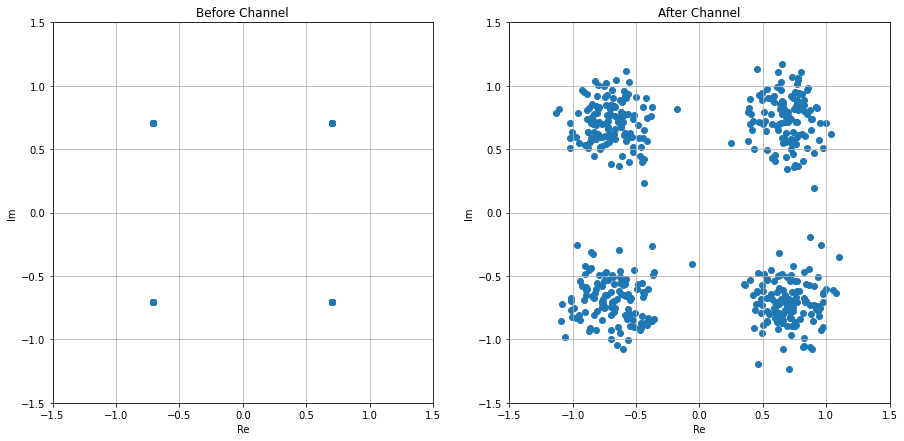

In [15]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import sksdr

# Create modulator
modem = sksdr.PSKModulator(sksdr.QPSK, [0,1,3,2], phase_offset=np.pi/4)

# Generate some random bits and modulate them
bits = np.random.randint(0, 2, 1000)
symbols = modem.modulate(bits)

# Create an AWGN channel with a given SNR, and pass symbols through it
awgn = sksdr.AWGNChannel(snr=12)
rx_symbols = awgn(symbols)

# Demodulate symbols
bits_out = modem.demodulate(rx_symbols)

# Setup figure
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1, 2, figure=fig)

# Plot constellations and show BER
f = sksdr.scatter_plot(symbols, 'Before Channel', fig=fig, gs=gs[0, 0])
f = sksdr.scatter_plot(rx_symbols, 'After Channel', fig=fig, gs=gs[0, 1])

print('BER: {}/{}'.format(*sksdr.ber(bits, bits_out)))
#plt.close('all')